In [30]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix,
    make_scorer, silhouette_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from scikitplot.helpers import binary_ks_curve
from matplotlib import pyplot
from sklearn.model_selection import validation_curve
from category_encoders import OneHotEncoder, TargetEncoder
from yellowbrick.model_selection import RFECV
from hyperopt import fmin, tpe, hp, Trials
from mlxtend.evaluate import bias_variance_decomp
from hyperopt import space_eval
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Set pandas options
pd.options.display.max_columns = None

# Ignore warnings
warnings.filterwarnings("ignore")

# Set plot figure size
plt.rcParams["figure.figsize"] = (16, 7)

# Additional imports (if needed)
from scikitplot.helpers import binary_ks_curve

### Read dataset

In [89]:
df_train = pd.read_csv('C:\\Users\\Bruno\\Desktop\\Aulas - Pessoal\\kedro\\santanderkaggle\\data\\01_raw\\train.csv')
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

### Define parameters

In [3]:
id_columns = ['ID']
target_column = ['TARGET']

y = df_train[target_column]
x = df_train.drop(columns=id_columns + target_column).fillna(0)

### Split train and test

In [4]:
from utils import variance_threshold
from utils import correlation
from utils import train_test_split_dist

test_size = 0.25
seed = 18051995
x = x.copy()
y = y.copy()


x_train, x_test, y_train, y_test = train_test_split_dist(x = x, y= y, test_size = test_size,seed=seed)

Number of rows in training set: 57015
---------------------------
Checking target distribution in the training set:
TARGET
0         96.043147
1          3.956853
Name: count, dtype: float64
---------------------------
Checking target distribution in the testing set:
Number of rows in testing set: 19005
---------------------------
TARGET
0         96.043147
1          3.956853
Name: count, dtype: float64


### Feature selection process

In [20]:
from utils import variance_threshold
from utils import correlation


variance = 0.01
corr = 0.8

def UnsupervisedFeatureSelection(x_train, variance, corr):
    """
    Perform unsupervised feature selection based on variance and correlation.

    Args:
        x_train (pandas.DataFrame): The training feature data.
        id_columns (list): List of ID columns that should be included.
        variance (float): Variance threshold for feature selection (default: 0.01).
        corr (float): Correlation threshold for feature selection (default: 0.8).

    Returns:
        list: A list of selected feature columns after feature selection.
    """
    # Define type of columns
    num_vars = x_train.select_dtypes(include=['float64', 'int64']).columns
    cat_vars = x_train.select_dtypes(include=['object']).columns

    print('initial numerical vars =', len(num_vars))
    print('initial categorical vars =', len(cat_vars))

     #Aplicando variance e correlação
    num_vars_vt = variance_threshold(x_train.filter(num_vars),threshold =variance)
    selected_columns = correlation(x_train.filter(num_vars_vt), threshold = corr)
    
    print('Total feature to keep =', len(selected_columns))
    return selected_columns

feature_to_keep = UnsupervisedFeatureSelection(x_train, variance, corr)

initial numerical vars = 369
initial categorical vars = 0
Total feature to keep = 126


initial number of vars = 126


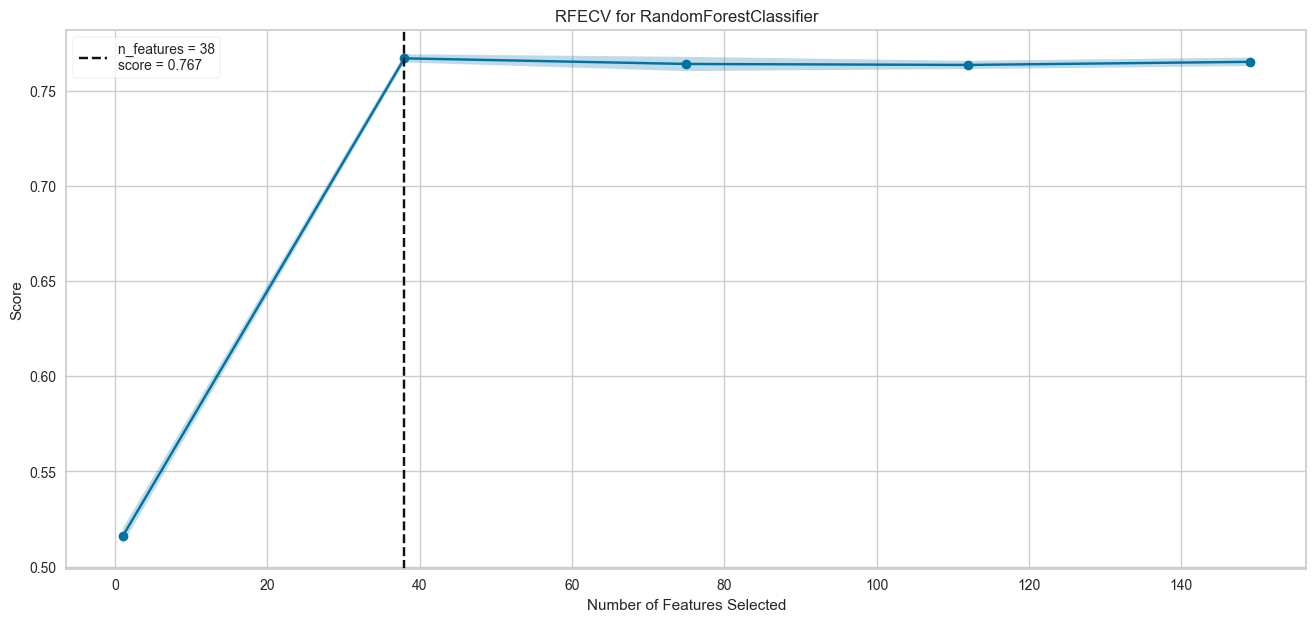

Optimal number of features: 38
Selected features: ['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1', 'imp_op_var41_efect_ult1', 'ind_var5', 'ind_var8_0', 'ind_var37_cte', 'ind_var39_0', 'num_var4', 'num_op_var41_hace2', 'num_op_var41_ult1', 'num_var30_0', 'num_var30', 'num_var37_med_ult2', 'saldo_var5', 'saldo_var8', 'saldo_var26', 'saldo_var30', 'saldo_var37', 'var36', 'imp_var43_emit_ult1', 'imp_trans_var37_ult1', 'num_ent_var16_ult1', 'num_var22_hace2', 'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3', 'num_med_var45_ult3', 'num_op_var41_efect_ult1', 'num_var43_emit_ult1', 'num_var43_recib_ult1', 'num_var45_hace3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult3', 'saldo_medio_var8_hace2', 'var38']


In [22]:
def SupervisedFeatureSelection(x_train,
                               y_train, 
                               features,
                               metric="roc_auc",
                               cv=3,
                               model = RandomForestClassifier(),
                               step=0.1):
    """
    Perform supervised feature selection using Recursive Feature Elimination with Cross-Validation (RFECV).

    Args:
        x_train (pandas.DataFrame): The training feature data.
        y_train (pandas.Series): The training target variable.
        id_columns (list): List of ID columns to be dropped.
        features (list): List of feature columns to select from.
        metric (str): The scoring metric for feature selection (default: "roc_auc").
        cv (int): Number of cross-validation folds (default: 3).
        step (float): The step size for feature elimination (default: 0.1).

    Returns:
        list: A list of selected feature columns.
    """
    # Filter and drop ID columns
    x_train = x_train[features].copy()
    print('initial number of vars =', len(x_train.columns))

    # Instantiate RFECV visualizer with a linear Random Forest classifier
    visualizer = RFECV(model, scoring=metric, cv=cv, step=step)

    # Fit the data to the visualizer
    visualizer.fit(x_train, y_train)

    # Display the feature selection plot
    visualizer.show()

    # Get the optimal number of selected features and the list of best features
    optimal_num_features = visualizer.n_features_
    best_features = list(x_train.columns[visualizer.support_])

    print('Optimal number of features:', optimal_num_features)
    print('Selected features:', best_features)
    
    return best_features

feature_to_keep_s = SupervisedFeatureSelection(x_train, y_train,features = feature_to_keep,step=0.3)

### Model train

In [70]:
def train_and_save_xgboost_model(x_train, y_train,features, seed=42, max_evals=30):
    """
    Train an XGBoost model with optimized hyperparameters and save it to a file.

    Parameters:
    - x_train (DataFrame): The training features.
    - y_train (Series): The target variable for training.
    - seed (int): Random seed for reproducibility. Default is 42.
    - max_evals (int): Maximum number of hyperparameter optimization evaluations. Default is 5.

    Returns:
    - model_xgb (XGBClassifier): Trained XGBoost model.

    This function trains an XGBoost model on the provided training data (x_train and y_train). It uses hyperparameter optimization
    with Bayesian optimization provided by Hyperopt to find the best set of hyperparameters for the model. The optimized model
    is then saved to a file using joblib.

    Example usage:
    model = train_and_save_xgboost_model(x_train, y_train, seed=42, max_evals=10)
    """
    
    x_train = x_train[features].copy()
    
    # Function for hyperparameter optimization
    def objective(params):
        """
        Objective function for hyperparameter optimization.

        Parameters:
        - params (dict): Dictionary of hyperparameters.

        Returns:
        - score (float): Negative ROC AUC score to be minimized.
        """
        params = {'max_depth': int(params['max_depth']),
                  'learning_rate': float(params['learning_rate']),
                  'n_estimators': int(params['n_estimators']),
                  'gamma': float(params['gamma']),
                  'min_child_weight': float(params['min_child_weight']),
                  'subsample': float(params['subsample']),
                  'colsample_bytree': float(params['colsample_bytree']),
                  'scale_pos_weight': int(params['scale_pos_weight'])
                 }

        clf = XGBClassifier(n_jobs=8,
                                objective='binary:logistic',
                                **params,
                                random_state=seed)

        score = cross_val_score(clf, x_train, y_train, scoring="roc_auc", cv=StratifiedKFold()).mean()

        print("Profit {:.3f} params {}".format(score, params))
        score = -1 * score
        return score

    space = {  # Hyperparameter search space
        'max_depth': hp.choice('max_depth', range(4, 8, 1)),
        'learning_rate': hp.quniform('learning_rate', 0.001, 0.01, 0.001),
        'n_estimators': hp.choice('n_estimators', range(50, 200, 20)),
        'gamma': hp.quniform('gamma', 5, 25, 5),
        'min_child_weight': hp.quniform('min_child_weight', 10, 50, 1),
        'subsample': hp.quniform('subsample', 0.4, 0.9, 0.01),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 0.9, 0.01),
        'scale_pos_weight': hp.choice('scale_pos_weight', range(3, 15, 1)),
    }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals)

    # Best optimized hyperparameters
    best_params = space_eval(space, best)
    print("Best parameters:", best_params)

    print("Training the best model")

    # Training the model with the best hyperparameters
    model_xgb = XGBClassifier(n_jobs=-1, random_state=seed, objective='binary:logistic', **best_params)
    model_xgb.fit(x_train, y_train)

    # Saving the model to a file
    model_filename = 'best_xgboost_model.pkl'
    joblib.dump(model_xgb, model_filename)
    print(f"XGBoost model trained and saved as '{model_filename}'")

    return model_xgb

model_xgb = train_and_save_xgboost_model(x_train, y_train,features = feature_to_keep_s, seed=42, max_evals=3)

Profit 0.838 params {'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 50, 'gamma': 15.0, 'min_child_weight': 14.0, 'subsample': 0.68, 'colsample_bytree': 0.76, 'scale_pos_weight': 14}
Profit 0.818 params {'max_depth': 6, 'learning_rate': 0.003, 'n_estimators': 130, 'gamma': 10.0, 'min_child_weight': 48.0, 'subsample': 0.84, 'colsample_bytree': 0.42, 'scale_pos_weight': 3}
Profit 0.829 params {'max_depth': 5, 'learning_rate': 0.004, 'n_estimators': 130, 'gamma': 10.0, 'min_child_weight': 46.0, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.53, 'scale_pos_weight': 11}
100%|█████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.57s/trial, best loss: -0.8382459664584742]
Best parameters: {'colsample_bytree': 0.76, 'gamma': 15.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 14.0, 'n_estimators': 50, 'scale_pos_weight': 14, 'subsample': 0.68}
Training the best model
XGBoost model trained and saved as 'best_xgboost_model.pkl'


### Model summary

In [80]:
import joblib
import xgboost as xgb
import pandas as pd

def load_xgboost_model_and_get_feature_importance(model):
    """
    Load a saved XGBoost model and get feature importance.

    Parameters:
    - model_filename (str): The filename of the saved XGBoost model.
    - x_train (DataFrame): The training features used for calculating feature importance.

    Returns:
    - model (XGBClassifier): Loaded XGBoost model.
    - feature_importance (DataFrame): DataFrame containing feature importance scores.

    This function loads a previously saved XGBoost model, calculates feature importance,
    and returns a DataFrame with feature importance scores.
    """
    
    # Get feature importance scores
    feature_scores = model.get_booster().get_score(importance_type='weight')
    total = sum(feature_scores.values())
    feature_importance = pd.DataFrame(sorted(feature_scores.items(), key=lambda x: x[1], reverse=True), columns=['Feature', 'Score'])
    feature_importance['Score'] = feature_importance['Score'] / total  # Normalize scores

    return feature_importance

model_summary = load_xgboost_model_and_get_feature_importance(model = model_xgb)
model_summary

,Feature,Score
0,var38,0.194825
1,var15,0.140586
2,saldo_var30,0.063591
3,saldo_medio_var5_hace3,0.060162
4,saldo_medio_var5_hace2,0.057357
5,saldo_medio_var5_ult3,0.050187
6,num_var22_ult3,0.043953
7,num_var45_hace3,0.040212
8,saldo_var5,0.033666
9,num_med_var45_ult3,0.031172


### Model train evaluation

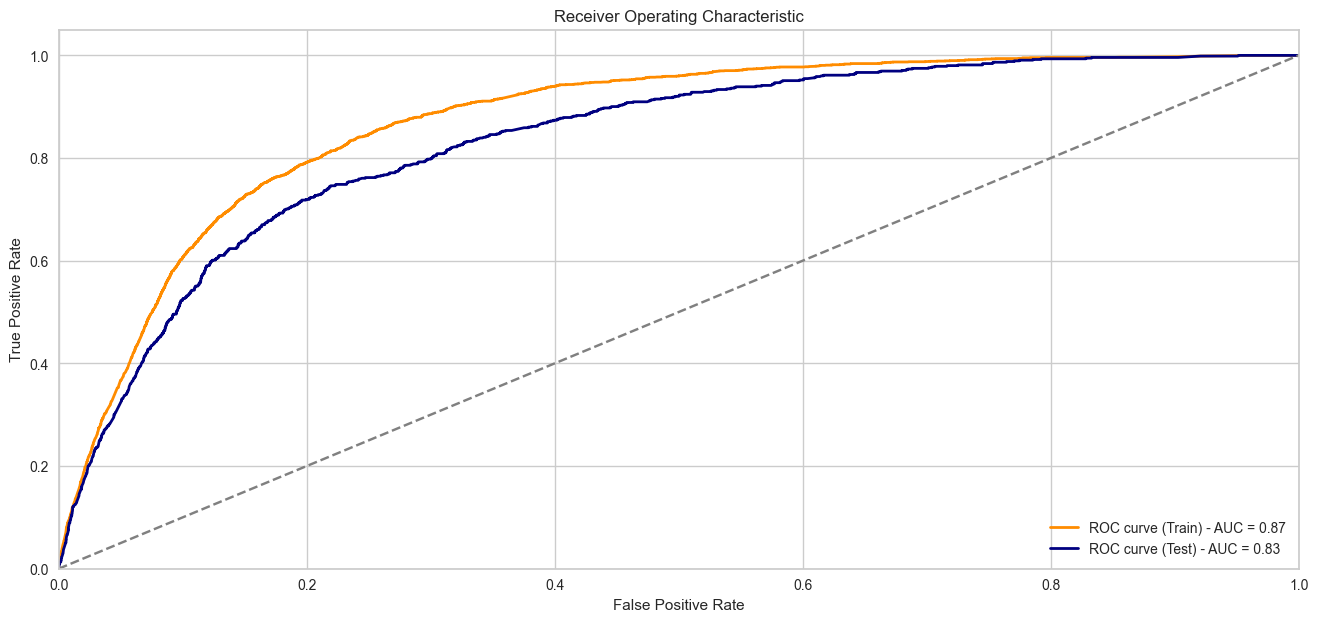

-----------------------------------------------------
ROC AUC Train = 0.872
ROC AUC Test = 0.833


,Dataset,ROC_AUC
0,Train,0.871978
1,Test,0.833037


In [87]:
def EvaluateModel(model, x_train, y_train, x_test, y_test, features):
    """
    Score the XGBoost model and calculate ROC AUC and KS statistics.

    Parameters:
    model : The trained classifier.
    x_train (pd.DataFrame): Training data features.
    y_train (pd.Series): Training data labels.
    x_test (pd.DataFrame): Test data features.
    y_test (pd.Series): Test data labels.
    feature_to_keep_s (list): List of selected features for scoring.

    Returns:
    pd.DataFrame: DataFrame with ROC AUC and KS statistics for training and test datasets.
    """

    #Filter feature in dataset
    x_train_scoring = x_train[features].copy()
    x_test_scoring = x_test[features].copy()

    # Scoring the model
    proba_train = model.predict_proba(x_train_scoring)[:, 1]
    proba_test = model.predict_proba(x_test_scoring)[:, 1]

    # Calculate ROC AUC scores
    auc_train = roc_auc_score(y_train, proba_train)
    auc_test = roc_auc_score(y_test, proba_test)

    # Calculate ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, proba_test)

    # Create a DataFrame with the statistics
    statistics_df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'ROC_AUC': [auc_train, auc_test]
    })

    # Plot the ROC curves
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (Train) - AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='ROC curve (Test) - AUC = {:.2f}'.format(auc_test))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print('-----------------------------------------------------')
    # Summarize scores
    print('ROC AUC Train = {:.3f}'.format(auc_train))
    print('ROC AUC Test = {:.3f}'.format(auc_test))

    return statistics_df

statistics = EvaluateModel(model_xgb, x_train, y_train, x_test, y_test, feature_to_keep_s)
statistics

### Scoring model

In [141]:
df_validation = pd.read_csv('C:\\Users\\Bruno\\Desktop\\Aulas - Pessoal\\kedro\\santanderkaggle\\data\\01_raw\\test.csv')

def scoring_dataframe(df, id_columns, features, model):
    """
    Create a DataFrame with deciles from a validation CSV file using a trained model.

    Parameters:
    - df: Path to the validation CSV file.
    - id_columns (str or list): The column(s) that act as unique identifiers.
    - features (list): List of feature columns to keep.
    - model: Trained machine learning model (e.g., XGBoost).

    Returns:
    - DataFrame: A DataFrame with 'score' and 'deciles' columns.

    """

    # Load the validation CSV file, filtering by the specified columns
    df_validation = df.set_index(id_columns)[features]

    # Use the model to predict the 'score' for each record
    df_validation['score'] = model.predict_proba(df_validation)[:, 1]
    
    #set df scoring
    scoring_df = df_validation[['score']]
    
    # Calculate the deciles
    scoring_df['deciles'] = pd.qcut(scoring_df['score'], q=10, labels=False)
    scoring_df['deciles'] = scoring_df['deciles'] + 1  # Start deciles from 1
    
    #print distribution
    result = scoring_df.groupby('deciles').size().reset_index(name='count')
    result = scoring_df.groupby('deciles').agg({'score': ['count', 'max', 'min']}).reset_index()
    print(result)

    return scoring_df

scoring_df = scoring_dataframe(df_validation
                               , id_columns
                               , feature_to_keep_s
                               , model_xgb)
scoring_df

  deciles score                    
          count       max       min
0       1  9679  0.240064  0.233901
1       2  5491  0.250098  0.240066
2       3  7576  0.262114  0.250100
3       4  7633  0.277491  0.262120
4       5  7530  0.295823  0.277492
5       6  7605  0.315803  0.295834
6       7  7560  0.341281  0.315820
7       8  7580  0.378268  0.341294
8       9  7584  0.464854  0.378288
9      10  7580  0.558603  0.464856


,score,deciles
ID,,
2,0.353506,8
5,0.375224,8
6,0.239102,1
7,0.276056,4
9,0.240064,1
...,...,...
151831,0.380624,9
151832,0.318464,7
151833,0.251597,3
